In [2]:
import pandas_datareader.data as pdr
import yfinance as yf
yf.pdr_override()
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from scipy.optimize import minimize

tickers = ['SPY', 'IEV', 'EWJ', 'EEM', 'TLT', 'IEF', 'IYR', 'RWX', 'GLD', 'DBC']
start = '2004-12-30'

all_data = {}
for ticker in tickers:
    all_data[ticker] = pdr.get_data_yahoo(ticker, start)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [18]:
# 딕셔너리에서 data중 수정주가부분만 갖고오고 그 중에 해당 티커만 데이터를 가져온다.
prices = pd.DataFrame({tic : data['Adj Close'] for tic, data in all_data.items()})
prices = prices.fillna(method = 'ffill')
# print(prices)

daily_ret = np.log(prices.pct_change()+1)
daily_ret.dropna()
print(daily_ret)
daily_cov = daily_ret.cov()
daily_cov

SPY       IEV       EWJ       EEM       TLT       IEF  \
Date                                                                     
2004-12-29       NaN       NaN       NaN       NaN       NaN       NaN   
2004-12-30 -0.001897  0.000530  0.009311 -0.002544  0.006703  0.003766   
2004-12-31 -0.002148 -0.004376  0.011976  0.008208  0.006287  0.001189   
2005-01-03 -0.004727 -0.000665 -0.011976 -0.010458  0.002144  0.001999   
2005-01-04 -0.012295 -0.022049 -0.016823 -0.031272 -0.010536 -0.006245   
...              ...       ...       ...       ...       ...       ...   
2020-07-23 -0.012003 -0.008374 -0.003394 -0.008073  0.011614  0.000981   
2020-07-24 -0.006461 -0.007032 -0.001074 -0.000927 -0.000059 -0.000490   
2020-07-27  0.007266  0.009832  0.019687  0.015412 -0.003718 -0.001554   
2020-07-28 -0.006363 -0.003734 -0.006166 -0.008251  0.006895  0.002371   
2020-07-29  0.012224  0.011391  0.000530  0.015982 -0.001704  0.001306   

                 IYR       RWX       GLD       DBC  
D

,SPY,IEV,EWJ,EEM,TLT,IEF,IYR,RWX,GLD,DBC
SPY,0.000154,0.000166,0.000128,0.000201,-0.000048,-0.000021,0.000186,0.000148,0.000005,0.000071
IEV,0.000166,0.000228,0.000156,0.000246,-0.000054,-0.000024,0.000202,0.000191,0.000025,0.000097
EWJ,0.000128,0.000156,0.000179,0.000193,-0.000035,-0.000016,0.000151,0.000143,0.000015,0.000063
EEM,0.000201,0.000246,0.000193,0.000360,-0.000060,-0.000028,0.000253,0.000222,0.000035,0.000118
TLT,-0.000048,-0.000054,-0.000035,-0.000060,0.000081,0.000034,-0.000043,-0.000043,0.000014,-0.000030
IEF,-0.000021,-0.000024,-0.000016,-0.000028,0.000034,0.000017,-0.000020,-0.000019,0.000008,-0.000012
IYR,0.000186,0.000202,0.000151,0.000253,-0.000043,-0.000020,0.000371,0.000195,0.000010,0.000076
RWX,0.000148,0.000191,0.000143,0.000222,-0.000043,-0.000019,0.000195,0.000202,0.000022,0.000082
GLD,0.000005,0.000025,0.000015,0.000035,0.000014,0.000008,0.000010,0.000022,0.000132,0.000055
DBC,0.000071,0.000097,0.000063,0.000118,-0.000030,-0.000012,0.000076,0.000082,0.000055,0.000150


In [5]:
# 위험기여도 계산 함수
def risk_contribution(weights):

    weights=np.array(weights)
    sigma = np.sqrt(np.dot(weights.T, np.dot(daily_cov, weights)))
    
    # marginal risk contribution
    mrc = 1/sigma * np.dot(daily_cov,weights)
    # risk contribution
    rc = weights * mrc
    # print(rc)
    # rc = rc/rc.sum()
    return rc

# risk parity 목적함수
# 참고 https://cran.r-project.org/web/packages/riskParityPortfolio/vignettes/RiskParityPortfolio.html
def riskparity_objective(weights):
    rc = risk_contribution(weights)
    # print(rc)
    arr = np.reshape(rc,(len(rc),1))
    risk_diffs = arr - arr.T
    sum_risk_diffs_squared = np.sum(np.square(np.ravel(risk_diffs)))
    
    return sum_risk_diffs_squared

In [6]:
# 제약조건
# 초기 비중 설정. 종목별로 동일하게 줌
initial_weights = len(prices.columns)*[1./len(prices.columns)]

# 종목 별 최소, 최대 비중을 정해줘야 함. 튜플로 최소를 0, 최대를 1로 지정함.
bnds = tuple((0,1) for x in range(len(prices.columns)))
# print(bnds)
# type으로 제약조건식이 등식인지, 부등식인지 정하고, fun에 관련 제약식을 함수로 적어줌
cons = ({'type':'eq', 'fun':lambda x:np.sum(x)-1},
    {'type': 'ineq', 'fun': lambda x:x})
options = {'ftol': 1e-20, 'maxiter': 800}
risk_parity_opt = minimize(riskparity_objective, initial_weights,
                      method = 'SLSQP',
                      constraints = cons,
                      bounds=bnds,
                      options=options)

[ 1.10844208e-03  1.37836651e-03  1.09366296e-03  1.72208863e-03
 -2.05717007e-04 -9.07636128e-05  1.54664106e-03  1.27789069e-03
  3.59292409e-04  7.49112667e-04]
[ 1.10844208e-03  1.37836651e-03  1.09366296e-03  1.72208863e-03
 -2.05717007e-04 -9.07636128e-05  1.54664106e-03  1.27789069e-03
  3.59292409e-04  7.49112667e-04]
[ 1.10844225e-03  1.37836652e-03  1.09366296e-03  1.72208863e-03
 -2.05717011e-04 -9.07636147e-05  1.54664106e-03  1.27789070e-03
  3.59292403e-04  7.49112665e-04]
[ 1.10844208e-03  1.37836673e-03  1.09366296e-03  1.72208863e-03
 -2.05717011e-04 -9.07636146e-05  1.54664106e-03  1.27789070e-03
  3.59292405e-04  7.49112666e-04]
[ 1.10844208e-03  1.37836651e-03  1.09366313e-03  1.72208863e-03
 -2.05717009e-04 -9.07636137e-05  1.54664106e-03  1.27789069e-03
  3.59292405e-04  7.49112663e-04]
[ 1.10844208e-03  1.37836652e-03  1.09366296e-03  1.72208890e-03
 -2.05717011e-04 -9.07636149e-05  1.54664106e-03  1.27789069e-03
  3.59292405e-04  7.49112665e-04]
[ 1.10844207e-03

In [13]:
risk_parity_opt

     fun: 7.644306601978285e-19
     jac: array([2.02815072e-11, 2.16218051e-11, 1.89414022e-11, 1.90203421e-11,
       1.63639250e-11, 1.72219464e-11, 1.65592764e-11, 1.87021232e-11,
       1.56898550e-11, 1.74723457e-11])
 message: 'Optimization terminated successfully.'
    nfev: 949
     nit: 79
    njev: 79
  status: 0
 success: True
       x: array([0.06165487, 0.04699255, 0.05607811, 0.0370938 , 0.17889514,
       0.37025119, 0.04032369, 0.04894496, 0.08542643, 0.07433928])

[ 1.10844208e-03  1.37836651e-03  1.09366296e-03  1.72208863e-03
 -2.05717007e-04 -9.07636128e-05  1.54664106e-03  1.27789069e-03
  3.59292409e-04  7.49112667e-04]


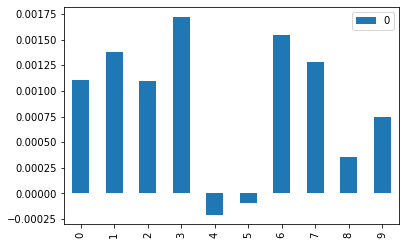

In [14]:
# risk parity 하기전 risk_contribution
rc_ew = risk_contribution(initial_weights)
pd.DataFrame(rc_ew).plot(kind = 'bar')

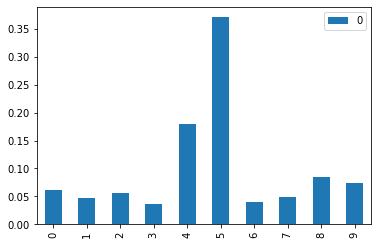

In [84]:
# 종목별 비중
rp_ew = risk_parity_opt.x
pd.DataFrame(rp_ew).plot(kind = 'bar')

[0.00047084 0.00047084 0.00047084 0.00047084 0.00047084 0.00047084
 0.00047084 0.00047084 0.00047084 0.00047084]
[0.00047084 0.00047084 0.00047084 0.00047084 0.00047084 0.00047084
 0.00047084 0.00047084 0.00047084 0.00047084]


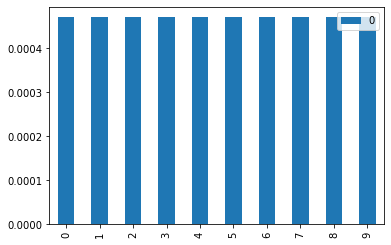

In [15]:
# 종목 risk contribution
rc_ew= risk_contribution(risk_parity_opt.x)
print(rc_ew)
pd.DataFrame(rc_ew).plot(kind = 'bar')

SPY    0.012413
IEV    0.015087
EWJ    0.013359
EEM    0.018979
TLT    0.008980
IEF    0.004112
IYR    0.019247
RWX    0.014202
GLD    0.011499
DBC    0.012256
dtype: float64


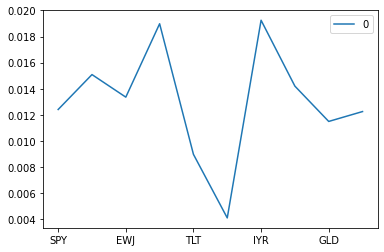

In [16]:
# 종목 변동성
var = np.std(daily_ret)
print(var)
pd.DataFrame(var).plot(kind = 'line')

In [9]:
rc=np.array([1,2,3,4,5,6,7,8,9,10])
print(rc)
arr = np.reshape(rc,(len(rc),1))
print(type(arr))
print(arr)
risk_diffs = arr - arr.T
print(risk_diffs)

[ 1  2  3  4  5  6  7  8  9 10]
<class 'numpy.ndarray'>
[[ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]]
[[ 0 -1 -2 -3 -4 -5 -6 -7 -8 -9]
 [ 1  0 -1 -2 -3 -4 -5 -6 -7 -8]
 [ 2  1  0 -1 -2 -3 -4 -5 -6 -7]
 [ 3  2  1  0 -1 -2 -3 -4 -5 -6]
 [ 4  3  2  1  0 -1 -2 -3 -4 -5]
 [ 5  4  3  2  1  0 -1 -2 -3 -4]
 [ 6  5  4  3  2  1  0 -1 -2 -3]
 [ 7  6  5  4  3  2  1  0 -1 -2]
 [ 8  7  6  5  4  3  2  1  0 -1]
 [ 9  8  7  6  5  4  3  2  1  0]]


In [12]:
a=np.array([[1,2,3],[4,5,6]])
print(a)
print(np.ravel(a))

[[1 2 3]
 [4 5 6]]
[1 2 3 4 5 6]
